#**Modules**

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras import regularizers, activations
from tensorflow.keras import initializers as init
from tensorflow.keras import optimizers as opti

import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, validation_curve 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse_fn

import numpy as np
import pandas as pd
from time import time 
from matplotlib import pyplot as plt
from google.colab import drive

from copy import deepcopy

#**Data Pre-processing**

In [ ]:
data = pd.read_csv('Churn_Modelling.csv')
data.keys(), len(data.keys())

In [ ]:
## Column 13 is Output Value
x = data.iloc[:, 3:13].values
y = data.iloc[:, 13].values
x[:10],y[:10]

In [4]:
## Label Region with 0,1,2 since there are only 3 countries
## Label Gender with 0,1
x[:, 1] = LabelEncoder().fit_transform(x[:, 1])
x[:, 2] = LabelEncoder().fit_transform(x[:, 2])
x[:10]

array([[619, 0, 0, 42, 2, 0.0, 1, 1, 1, 101348.88],
       [608, 2, 0, 41, 1, 83807.86, 1, 0, 1, 112542.58],
       [502, 0, 0, 42, 8, 159660.8, 3, 1, 0, 113931.57],
       [699, 0, 0, 39, 1, 0.0, 2, 0, 0, 93826.63],
       [850, 2, 0, 43, 2, 125510.82, 1, 1, 1, 79084.1],
       [645, 2, 1, 44, 8, 113755.78, 2, 1, 0, 149756.71],
       [822, 0, 1, 50, 7, 0.0, 2, 1, 1, 10062.8],
       [376, 1, 0, 29, 4, 115046.74, 4, 1, 0, 119346.88],
       [501, 0, 1, 44, 4, 142051.07, 2, 0, 1, 74940.5],
       [684, 0, 1, 27, 2, 134603.88, 1, 1, 1, 71725.73]], dtype=object)

In [5]:
## Encode labels into one hot vectors
ct = ColumnTransformer([("Geography", OneHotEncoder(), [1]),
                        ("Gender", OneHotEncoder(), [2]),
                        ("HasCrCard", OneHotEncoder(), [7]),
                        ("IsActiveMember", OneHotEncoder(), [8])], remainder = 'passthrough')
x = ct.fit_transform(x)
print(len(x[0]),x[0])
 
#First 3 are geometry # Then 2 are gender # Then rest of the features

15 [1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 1.0 619 42 2 0.0 1 101348.88]


In [21]:
x_train, x_test, y_train, y_test = [np.asarray(d).astype(np.float32) for d in train_test_split(x, y, test_size = 0.2, random_state = 1, shuffle = 1)]
x_train.shape, y_train.shape

((8000, 15), (8000,))

In [29]:
## Normalize the data
norm = StandardScaler()
x_train = norm.fit_transform(x_train)
x_test = norm.transform(x_test)

# **Build Function**

* features: number of features **default** = 15
* dim : dimension architechture as list **default** = [12, 12, 1]
* fns : activation functions list, **default** = ['relu',  'relu', 'sigmoid'] 
* ini : initial weights for each layers, **default** = 'uniform'
* alpha : regularization parameter, **default** = 0
* los : loss function, **default** = 'binary_crossentropy'
* opt : optimizing Function, **default** =  'adam'
* metric : Evaluation Metric, **default** = 'accuracy'
* Batch_Normalize : 'after', 'before'; **default** = None
* drop : dropout rates list, **default** = None

In [ ]:
def build(features= 15, dim= [12,12,1], fns= [activations.relu,activations.relu,'sigmoid'], ini= 'uniform', alpha=0, los='binary_crossentropy', opt='adam', metric = 'accuracy', Batch_Normalize= None, drop= None):
  
  reg = regularizers.l2(alpha);
  
  model = Sequential()

  ### Input Layer
  model.add(keras.Input(shape=(features,)))

  for i in range(len(dim)-1):
    if Batch_Normalize == None:
      model.add(Dense(dim[i], fns[i], 1, ini, ini, reg, reg, reg))
      if drop: model.add(Dropout(drop[i]))
    elif Batch_Normalize == 'before':
      model.add(Dense(units= dim[i], kernel_initializer=ini, bias_initializer=ini, kernel_regularizer= reg, bias_regularizer=reg,activity_regularizer=reg))
      if drop: model.add(Dropout(drop[i]))
      model.add(BatchNormalization())
      model.add(Activation(fns[i]))
    elif Batch_Normalize == 'after':
      model.add(Dense(units= dim[i], kernel_initializer=ini, bias_initializer=ini, kernel_regularizer= reg, bias_regularizer=reg,activity_regularizer=reg))
      if drop: model.add(Dropout(drop[i]))
      model.add(Activation(fns[i]))
      model.add(BatchNormalization())
    else:
      return print('Invalid Batch_Normalize type')
  
  ### Output Layer
  model.add(Dense(dim[-1], fns[-1], 1, ini, ini, reg, reg, reg))

  model.compile(loss=los, optimizer=opt, metrics=[metric])
  return model

# **Train Function**

* model, epoch, batch, w, x, y, xt, yt
* **Default:** epoch = 250, batch = 250, x = x_train, y = y_train, xt = x_test, yt = y_train, w = 0
* set w = 1, if also want weights in outputs

In [149]:
def train(model, epoch= 250, batch= 250, w= 0, x = x_train, y = y_train, xt = x_test, yt = y_test):
  w_before = model.get_weights()
  history = model.fit(x, y, epochs=epoch, batch_size=batch, verbose=0, validation_data=(xt,yt)).history
  w_after = model.get_weights()
  if w:
    return history, w_before, w_after
  else:
    return history

# Helper Functions

In [127]:
def myplot(hist, metric= 'accuracy', st= 0, en= -1, label= 'Train'):
  if en == -1:
    en = len(hist[metric])
  
  st = int(st)
  en = int(en)

  x = np.linspace(st+1,en,en-st)
  acc = hist[metric][st:en]

  plt.plot(x,acc,label= label)

  plt.xlabel('Epochs')
  plt.ylabel(metric)

# **Model Architecture**

Input * Layer1 * Layer2 * Output 

15 * 12 * 12 * 1

Activations: relu, relu, sigmoid 


In [288]:
Base_Model = build()
history = train(Base_Model)
history.keys() 
for layer in Base_Model.layers:
  print(layer.output_shape)

(None, 12)
(None, 12)
(None, 1)


63/63 [==============================] - 0s 1ms/step - loss: 0.3370 - accuracy: 0.8645


[0.33701926469802856, 0.8644999861717224]

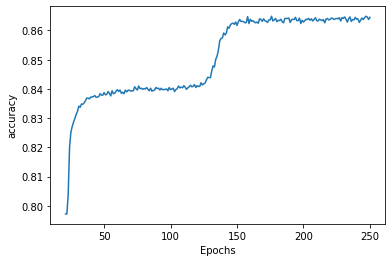

In [289]:
myplot(history,st=20)
M.evaluate(x_test,y_test)

# Q.1 Varying Initial Weights

In [137]:
tf.random.set_seed(1)
types = [init.RandomUniform(-0.5,0.5), init.GlorotNormal(), init.HeNormal(), init.Zeros()]
names = ['RandomUniform','GlorotNormal','HeNormal','Zeros']

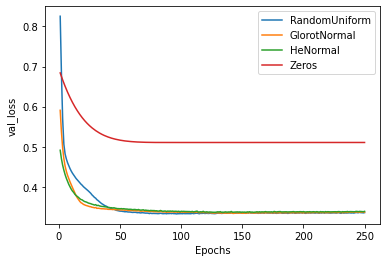

In [165]:
Model, Hist, W_before, W_after = {},{},{},{}

for i in range(4):
  Model[i] = build(ini = types[i])
  Hist[i], W_before[i], W_after[i] = train(Model[i],w=1)
  myplot(Hist[i],'val_loss',label=names[i])

plt.legend(loc='best')
plt.show()

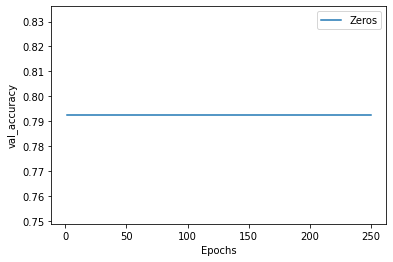

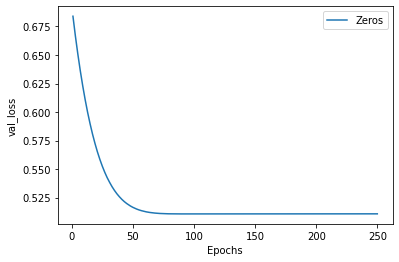

In [169]:
## Closer Look at the case of Zeros as Initial Weights

myplot(Hist[3], 'val_accuracy', 0, -1, names[3])
plt.legend(loc='best')
plt.show()

myplot(Hist[3], 'val_loss', 0, -1, names[3])
plt.legend(loc='best')
plt.show()

**Observation**

* Clearly, for Initial Weights = 0, the model is not getting trained, Since for epoch = 0 to 250 we are getting the same accuracy
* Note that accuracy = 0.796 , is because of the data distibution having most of the labels = 0
* Note that here: val_loss = Testing Error, val_Accuracy = Testing Accuracy

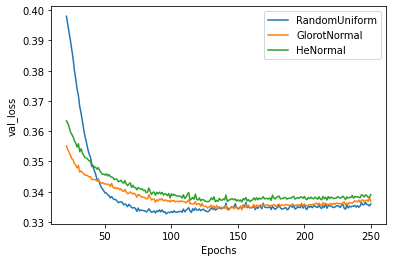

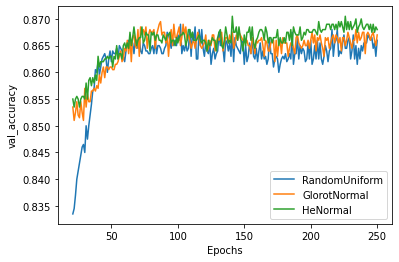

In [170]:
## Closer look at the rest of the Initializations

for i in range(3):
  myplot(Hist[i],'val_loss', 20, -1, names[i])

plt.legend(loc='best')
plt.show()

for i in range(3):
  myplot(Hist[i],'val_accuracy', 20, -1, names[i])

plt.legend(loc='best')
plt.show()

**Observation**

* We observe that The difference between learning of for all the different weight initialization is **negligible**, this shows that Neural Network Architecture is **stable enough** to handle any type of weight initializations

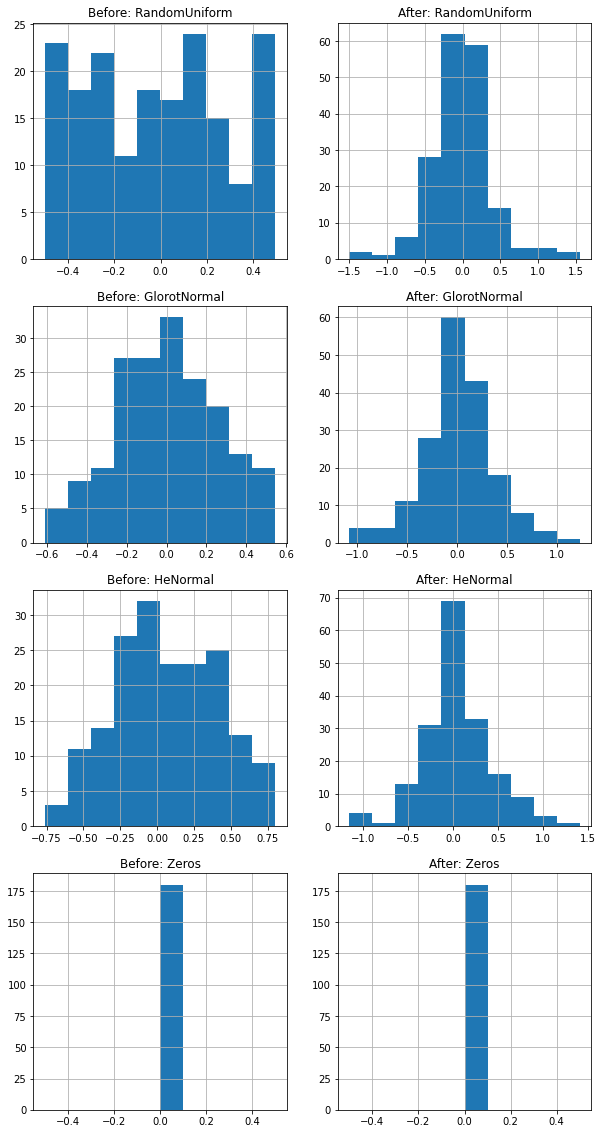

In [171]:
## Visualizing Histograms for 1st Layer
bins = 10
layer = 0
k = 1

plt.figure(figsize=(10, 20))
for i in range(4):
  plt.subplot(4,2,k)
  plt.hist(W_before[i][layer].flatten(),bins)
  plt.title('Before: '+names[i]);plt.grid()
  plt.subplot(4,2,k+1)
  plt.hist(W_after[i][layer].flatten(),bins)
  plt.title('After: ' + names[i]);plt.grid()
  k = k + 2
plt.show()

**Observation**

* Weight Distribution for the Zeros Initialization, remains the same, because there is not training
* For the rest of the initializations distributions are almost same, in the sense of frequency distribution

# Q.2 Varying Optimizers



In [195]:
rate = 0.001
types = [opti.Adam(rate),opti.SGD(rate),opti.Nadam(rate),opti.Adagrad(rate)]
names = ['Adam','SGD','Nadam','Adagrad']

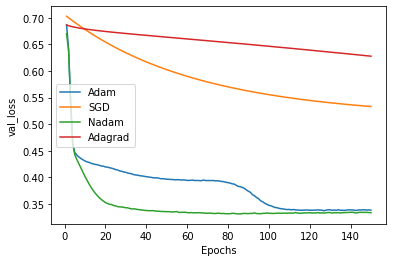

In [196]:
Model, Hist = {},{}

for i in range(4):
  Model[i] = build(opt = types[i])
  Hist[i] = train(Model[i],epoch=150)
  myplot(Hist[i],'val_loss',label=names[i])

plt.legend(loc='best')
plt.show()

In [192]:
rate = 0.1
types = [opti.Adam(rate),opti.SGD(rate),opti.Nadam(rate),opti.Adagrad(rate)]
names = ['Adam','SGD','Nadam','Adagrad']

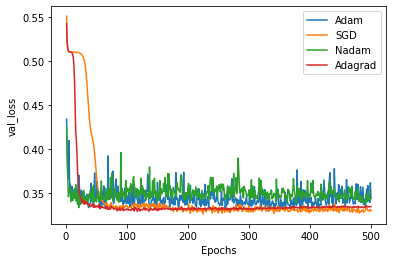

In [193]:
Model, Hist = {},{}

for i in range(4):
  Model[i] = build(opt = types[i])
  Hist[i] = train(Model[i],epoch=500)
  myplot(Hist[i],'val_loss',label=names[i])

plt.legend(loc='best')
plt.show()

**Observation**

* We can see that, ADAM and NADAM optimizers are pretty fast as compared to SGD and Adagrad (see fig.1)
* But in cases of large learning rates, convergence of SGD and Adagrad is smooth, where as ADAM and NADAM might show diverging behaviour in such cases, i.e. for very large value of epochs (see fig.2)
* Comparing SGD with Adagrad , Adagrad gives fast convergence, while keeping smoothness of the learning curve.
* But looking at over all charecteristics, by setting a lower learning rate, we can train our data very faster, by using adam and nadam.
* Nadam is the best optimizer for our dataset, given the learning rate is small enough.  

# Q.3 Batch Normalization



In [277]:
types = [None,'before','after']
names = ['Without Batch Normalization','Batch Normalization Before Activation','Batch Normalization After Activation']

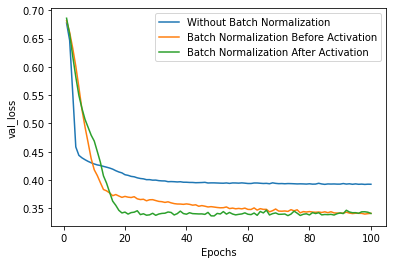

In [279]:
Model, Hist = {},{}

for i in range(len(types)):
  Model[i] = build(Batch_Normalize= types[i])
  Hist[i] = train(Model[i],epoch=100)
  myplot(Hist[i],'val_loss',label=names[i])

plt.legend(loc='best')
plt.show()

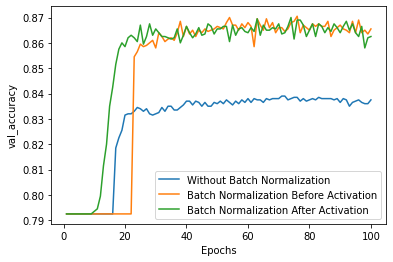

In [280]:
for i in range(len(types)):
  myplot(Hist[i],'val_accuracy',label=names[i])

plt.legend(loc='best')
plt.show()

**Observation**

* Using Batch Normalization we get the convergence even faster, and accuracy seem to have increased a bit.
* The observations from theory which say Batch Normalization stabilizes the learning process and dramatically reduces the number of training epochs required to train deep networks, can be solidified using this type of results
* Although we are not able to see any difference in results between Before Activation and After activation cases, for this particular dataset

# Q.3 Dropout




Let's choose an overfitting model to get eaily distinguishable results in our experiment

In [294]:
dim = [128]*3 + [1]
fns = ['relu']*3 + ['sigmoid']

Model = build(dim=dim,fns=fns)
history = train(Model) 

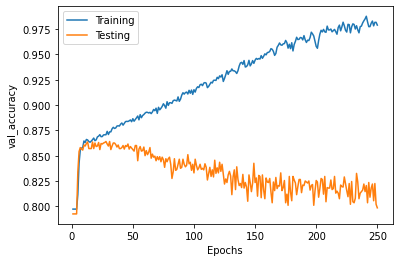

In [295]:
myplot(history,label='Training')
myplot(history,'val_accuracy',label='Testing')
plt.legend(loc='best')
plt.show()

We can clearly see the model is overfitting here, since the Accuracy of testing is falling rapidly as the epochs increase

In [298]:
types = [None, [0.3]*3, [0.6]*3, [0.9]*3]
names = ['Without Dropout','Dropout Rate = 0.3','Dropout Rate = 0.6','Dropout Rate = 0.9']

In [302]:
Model, Hist = {},{}

for i in range(len(types)):
  Model[i] = build(dim=dim,fns=fns,drop = types[i])
  Hist[i] = train(Model[i])

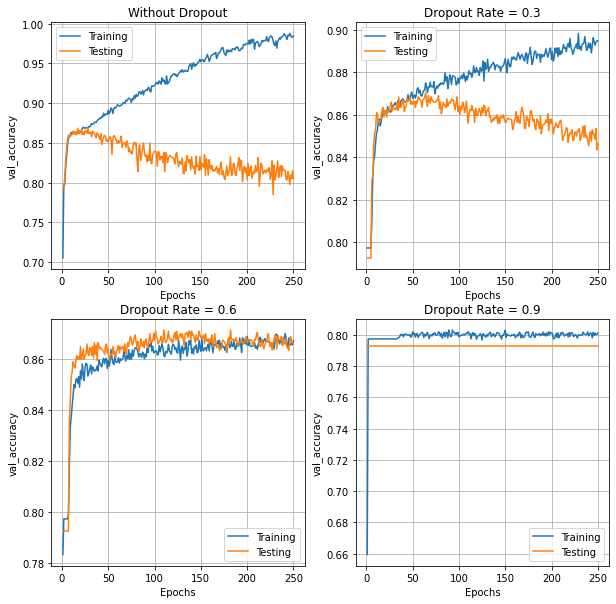

In [303]:
plt.figure(figsize=(10, 10))
for i in range(len(types)):
  plt.subplot(2,2,i+1)
  myplot(Hist[i],label='Training')
  myplot(Hist[i],'val_accuracy',label='Testing')
  plt.legend(loc='best')
  plt.title(names[i])
  plt.grid()
plt.show()

**Observation**

* Dropout Method can simply be used to reduce overfitting by dropping some of the nodes in the layer architecture
* The overfitting model shows very big gap in testing and training accuracies (Without Dropout)
* After introducing some dropout rate (dropout rate = 0.3), we observe this gap has decreased
* In subfigure (dropout rate = 0.6) we can clearly see how by increasing the dropout rate we can **close the gap** between testing and training accuracy
* Although dropping some nodes is good to reduce overfitting, if increase dropout rate too much, we get underfitting, Hence the model in the last subfigure (dropout rate= 0.9) is not getting trained at all (constant accuracy from the beginning of training)
* Hence by choosing an appropriate dropout rate, we can reduce the overfitting drastically.